
**Sales Forecasting Project - Wiseanalytics Data Science Internship**

In [5]:
# Part 1: Data Processing and Feature Engineering (Day 1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense



In [6]:
#Part 1: Data Processing and Feature Engineering (Day 1)
# Load datasets
train = pd.read_csv("/content/train.csv", parse_dates=['date'])
test = pd.read_csv("/content/test.csv", parse_dates=['date'])
stores = pd.read_csv("/content/stores.csv")
oil = pd.read_csv("/content/oil.csv", parse_dates=['date'])
holidays = pd.read_csv("/content/holidays_events.csv", parse_dates=['date'])
transactions = pd.read_csv("/content/transactions.csv", parse_dates=['date'])

In [7]:
# 1. Data Cleaning

# Handle missing values in oil prices
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

# Convert date columns to proper datetime formats
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Convert 'date' column in oil DataFrame to datetime
oil['date'] = pd.to_datetime(oil['date']) # This line is added to convert oil['date'] to datetime

# Convert 'date' column in holidays_events DataFrame to datetime
holidays['date'] = pd.to_datetime(holidays['date']) # This line is added to convert holidays_events['date'] to datetime

# Merge datasets
# Check if columns from stores already exist in train, if not, then merge
if not set(['store_nbr', 'city', 'state', 'type', 'cluster']).issubset(train.columns):
    train = train.merge(stores, on='store_nbr', how='left', suffixes=('', '_store')) # Changed 'store_id' to 'store_nbr' in the 'on' parameter
# Check if columns from oil already exist in train, if not, then merge
if not set(['date', 'dcoilwtico']).issubset(train.columns):
    train = train.merge(oil, on='date', how='left', suffixes=('', '_oil')) # Add suffixes to avoid duplicate column names
# Check if columns from holidays_events already exist in train, if not, then merge
if not set(['date', 'type', 'locale', 'locale_name', 'description', 'transferred']).issubset(train.columns): # This line was corrected by adding the missing closing bracket and quote
    train = train.merge(holidays, on='date', how='left', suffixes=('', '_holidays')) # Add suffixes to avoid duplicate column names

In [8]:
# Extract time-based features
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

# Create binary flags for holidays and promotions
# Check if 'type_holidays_events' column exists, indicating a holiday
train['is_holiday'] = train['type_holidays'].apply(lambda x: 1 if pd.notnull(x) and x in ['Holiday', 'Transfer'] else 0)

# Check if 'promo' column exists before creating 'is_promotion'
if 'promo' in train.columns:
    train['is_promotion'] = train['promo'].notnull().astype(int)
else:
    # Handle the case where 'promo' column is missing
    # For example, you can create a new column with all values set to 0
    train['is_promotion'] = 0

# Compute rolling statistics
train['rolling_mean'] = train['sales'].rolling(window=7).mean()
train['rolling_std'] = train['sales'].rolling(window=7).std()

In [9]:

# Extract time-based features
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

# Create binary flags for holidays and promotions
# Check if 'type_holidays_events' column exists, indicating a holiday
train['is_holiday'] = train['type_holidays'].apply(lambda x: 1 if pd.notnull(x) and x in ['Holiday', 'Transfer'] else 0)

# Check if 'promo' column exists before creating 'is_promotion'
if 'promo' in train.columns:
    train['is_promotion'] = train['promo'].notnull().astype(int)
else:
    # Handle the case where 'promo' column is missing
    # For example, you can create a new column with all values set to 0
    train['is_promotion'] = 0

# Compute rolling statistics
train['rolling_mean'] = train['sales'].rolling(window=7).mean()
train['rolling_std'] = train['sales'].rolling(window=7).std()

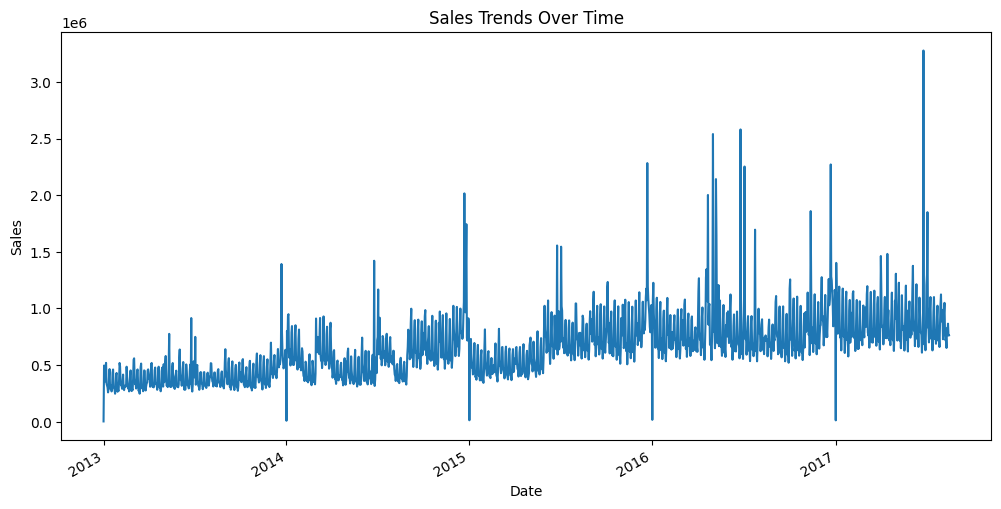

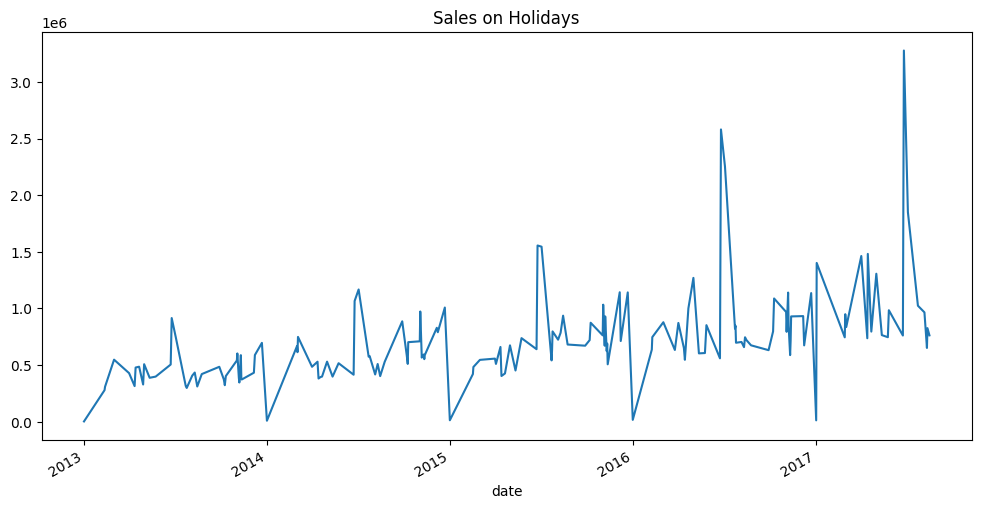

In [10]:
# Visualize sales trends over time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
train.groupby('date')['sales'].sum().plot()
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Analyze sales before and after holidays
holiday_sales = train[train['is_holiday'] == 1].groupby('date')['sales'].sum()
plt.figure(figsize=(12, 6))
holiday_sales.plot()
plt.title('Sales on Holidays')
plt.show()

**Part** 2: Model Selection, Forecasting, and Evaluation (Day 2)

In [ ]:
# Prepare data for modeling
X = train.drop(['sales', 'date'], axis=1)

# Convert categorical features to numerical using one-hot encoding
categorical_features = ['family', 'city', 'state', 'type', 'locale', 'locale_name', 'description', 'type_holidays']  # List of categorical features
categorical_features.append('transferred')
X['transferred'] = pd.to_numeric(X['transferred'], errors='coerce').fillna(0).astype(int) # Convert to numeric, handle errors, fill NaNs with 0 and convert to int
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = train['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.fillna(y_train.mean())
# Baseline Model
baseline_pred = y_train.mean()

# ARIMA Model
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Random Forest Regressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# XGBoost Model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predictions
rf_pred = rf_model.predict(X_val)
xgb_pred = xgb_model.predict(X_val)

# Calculate RMSE and MAPE
# Take the square root of MSE to get RMSE
rf_rmse = mean_squared_error(y_val, rf_pred)**0.5
xgb_rmse = mean_squared_error(y_val, xgb_pred)**0.5

rf_mape = mean_absolute_percentage_error(y_val, rf_pred)
xgb_mape = mean_absolute_percentage_error(y_val, xgb_pred)

print(f'Random Forest RMSE: {rf_rmse}, MAPE: {rf_mape}')
print(f'XGBoost RMSE: {xgb_rmse}, MAPE: {xgb_mape}')

In [ ]:
# Plot historical sales and predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val, label='Actual Sales')
plt.plot(y_val.index, rf_pred, label='RF Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()